# Superposition

Data from 
Winters, A. C., Keyser, D., Bosart, L. F., & Martin, J. E. (2020). Composite Synoptic-Scale Environments Conducive to North American Polar–Subtropical Jet Superposition Events. https://doi.org/10.1175/MWR-D-19-0353.1

In [26]:
from pathlib import Path
import numpy as np
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import seaborn as sns
from pathlib import Path
import re

In [27]:
regime_map = {
    "PolarDominant": "PD",
    "SubtropicalDominant": "SD",
    "WestSubtropicalDominant": "WS",
    "EastSubtropicalDominant": "ES",
    "Hybrid": "H",
}

# Folder where .txt files live
data_dir = Path("/scratch2/mabeling/data/ERA5/plev/high_wind/6H/Superpositions/")
dfs = []
for file in data_dir.glob("JetSuperpositions_*.txt"):
    match = re.search(r"JetSuperpositions_(\w+)\.txt", file.name)
    regime_key = match.group(1) if match else None
    regime_code = regime_map.get(regime_key, "Unknown")

    df = pl.read_csv(file, separator=",", ignore_errors=True)
    df = df.with_columns(pl.lit(regime_code).alias("regime"))
    dfs.append(df)

superpositions = pl.concat(dfs)

print(superpositions.head())
print(superpositions["regime"].unique())

shape: (5, 10)
┌────────┬───────┬──────┬──────┬───┬─────────────┬─────────────┬────────────┬────────┐
│ Year   ┆ Month ┆ Day  ┆ Hour ┆ … ┆ Grid_Points ┆ Event_Index ┆ Event_Type ┆ regime │
│ ---    ┆ ---   ┆ ---  ┆ ---  ┆   ┆ ---         ┆ ---         ┆ ---        ┆ ---    │
│ f64    ┆ f64   ┆ f64  ┆ f64  ┆   ┆ i64         ┆ i64         ┆ i64        ┆ str    │
╞════════╪═══════╪══════╪══════╪═══╪═════════════╪═════════════╪════════════╪════════╡
│ 1979.0 ┆ 11.0  ┆ 19.0 ┆ 4.0  ┆ … ┆ 27          ┆ 3           ┆ 2000       ┆ SD     │
│ 1979.0 ┆ 11.0  ┆ 21.0 ┆ 1.0  ┆ … ┆ 21          ┆ 4           ┆ 2000       ┆ SD     │
│ 1979.0 ┆ 12.0  ┆ 14.0 ┆ 1.0  ┆ … ┆ 22          ┆ 6           ┆ 2000       ┆ SD     │
│ 1980.0 ┆ 2.0   ┆ 18.0 ┆ 3.0  ┆ … ┆ 27          ┆ 8           ┆ 2000       ┆ SD     │
│ 1980.0 ┆ 11.0  ┆ 17.0 ┆ 1.0  ┆ … ┆ 28          ┆ 12          ┆ 2000       ┆ SD     │
└────────┴───────┴──────┴──────┴───┴─────────────┴─────────────┴────────────┴────────┘
shape: (5,)
Series: 'regime'

In [28]:
superpositions = (superpositions
    .with_columns(
        # ensure hours are multiples of 6 and valid (0–18)
        pl.when(pl.col("Hour") > 3)
        .then(3)  # cap values above 3
        .otherwise(pl.col("Hour"))
        .alias("Hour6")
    )
    .with_columns(
        pl.datetime(
            pl.col("Year").cast(int),
            pl.col("Month").cast(int),
            pl.col("Day").cast(int),
            (pl.col("Hour6") * 6).cast(int)
        ).alias("time")))

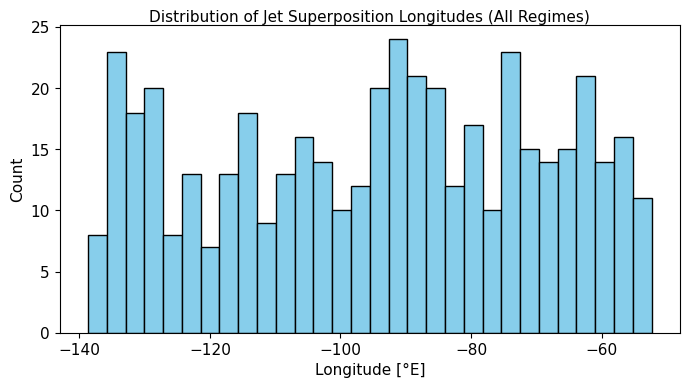

In [29]:
plt.figure(figsize=(8,4))
plt.hist(superpositions["Event_Longitude"], bins=30, color="skyblue", edgecolor="black")
plt.xlabel("Longitude [°E]")
plt.ylabel("Count")
plt.title("Distribution of Jet Superposition Longitudes (All Regimes)")
plt.show()

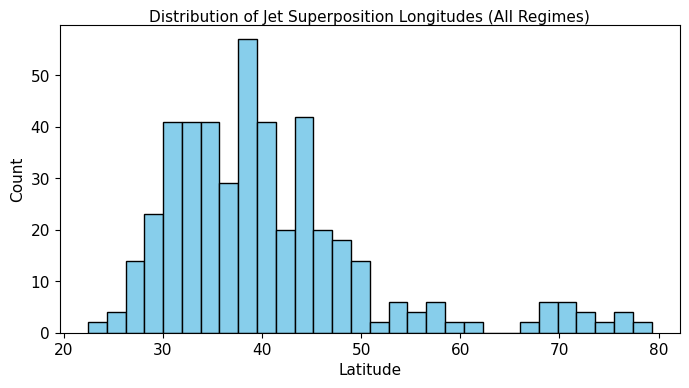

In [30]:
plt.figure(figsize=(8,4))
plt.hist(superpositions["Event_Latitude"], bins=30, color="skyblue", edgecolor="black")
plt.xlabel("Latitude")
plt.ylabel("Count")
plt.title("Distribution of Jet Superposition Longitudes (All Regimes)")
plt.show()

In [31]:
from matplotlib.patches import Wedge

def plot_superposition_hotspots(superpositions, 
                                grid_res=(5, 2.5), #(10, 5), 
                                marker_scale=0.04):
    """
    Plot aggregated superposition hotspots:
      - marker size ∝ number of events
      - color = regime (split if multiple)
    """
    df = superpositions.to_pandas()
    
    df = df[df["regime"] != "SD"] 

    if "Event_Latitude" not in df.columns:
        df["Event_Latitude"] = 30 + 25*np.random.rand(len(df))
    if "Event_Longitude" not in df.columns:
        df["Event_Longitude"] = ((df["Event_Longitude"] + 180) % 360) - 180

    # define regimes and colors
    regime_colors = {
        "PD": "royalblue",
        #"SD": "tomato",
        "H": "purple",
        "WS": "orange",
        "ES": "green"
    }

    lon_bins = np.arange(-180, 181, grid_res[0])
    lat_bins = np.arange(-90, 91, grid_res[1])
    df["lon_bin"] = pd.cut(df["Event_Longitude"], lon_bins, labels=lon_bins[:-1])
    df["lat_bin"] = pd.cut(df["Event_Latitude"], lat_bins, labels=lat_bins[:-1])

    grouped = (
        df.groupby(["lon_bin", "lat_bin"])
          .agg({"regime": list})
          .reset_index()
          .dropna(subset=["lon_bin", "lat_bin"])
    )

    def count_safe(x):
        if isinstance(x, (list, tuple)):
            return len(x)
        elif pd.isna(x):
            return 0
        else:
            return 1

    grouped["count"] = grouped["regime"].apply(count_safe)
    grouped["lon"] = grouped["lon_bin"].astype(float)
    grouped["lat"] = grouped["lat_bin"].astype(float)

    fig = plt.figure(figsize=(10,5))
    ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=210))
    ax.add_feature(cfeature.COASTLINE, lw=0.6)
    ax.add_feature(cfeature.BORDERS, lw=0.3)
    ax.add_feature(cfeature.LAND, color="lightgray", alpha=0.3)
    ax.gridlines(draw_labels=True, linewidth=0.3, color="gray", alpha=0.4)
    ax.set_extent([-160, -40, 10, 80])  # N Pacific + N America

    for _, row in grouped.iterrows():
        regimes = row["regime"]
        counts = row["count"]
        lon, lat = row["lon"], row["lat"]

        if regimes is None:
            continue
        if isinstance(regimes, (float, int)):
            if pd.isna(regimes):
                continue
            regimes = [regimes]
        elif isinstance(regimes, str):
            regimes = [regimes]
        elif isinstance(regimes, (np.ndarray, list, tuple)):
            regimes = [r for r in regimes if isinstance(r, str) and r.strip()]
        else:
            continue 


        size = marker_scale * counts  # control multiplier

        # One regime -> single color circ
        if len(set(regimes)) == 1:
            color = regime_colors.get(regimes[0], "gray")
            ax.scatter(
                lon, lat, s=(size*100)**2, color=color, alpha=0.7,
                edgecolor="k", linewidth=0.3, transform=ccrs.PlateCarree(), zorder=5
            )
        else:
            # multiple regimes: draw pie
            total = len(regimes)
            unique, counts_per = np.unique(regimes, return_counts=True)
            start = 0
            for reg, cnt in zip(unique, counts_per):
                frac = cnt / total
                end = start + 360*frac
                wedge = Wedge(
                    (lon, lat), size*10, start, end,
                    facecolor=regime_colors.get(reg, "gray"),
                    transform=ccrs.PlateCarree(),
                    lw=0.3, ec="k", alpha=0.8, zorder=10
                )
                ax.add_patch(wedge)
                start = end
                
    regime_handles = [
        Line2D([], [], marker="o", color="w", markerfacecolor=col, 
               markeredgecolor="k", label=reg, markersize=6)
        for reg, col in regime_colors.items()
    ]
    
    max_count = grouped["count"].max()
    print(max_count)
    #legend_scale = marker_scale * 0.1 
    size_examples = [6, 12, 24]
    size_handles = [
        plt.scatter([], [], s=(marker_scale * np.sqrt(n) * 300)**2,
                    color="gray", alpha=0.4, edgecolor="k", label=f"{n}")
        for n in size_examples
    ]
    leg1 = ax.legend(
        handles=size_handles, title="Event count",
        loc="lower right", frameon=True,
        fontsize=8, title_fontsize=8,
        borderpad=1.1, handletextpad=0.6, labelspacing=1.75,
        bbox_to_anchor=(1, 0.0)  # move outside map if needed
    )
    ax.add_artist(leg1)

    leg2 = ax.legend(
        handles=regime_handles, title="Superposition\n       Type",
        loc="lower left", frameon=True,
        fontsize=7.5, title_fontsize=8,
        borderpad=0.6, handletextpad=0.55, labelspacing=0.9,
        bbox_to_anchor=(-0.005, -0.005)
    )


    plt.title("Jet Superposition Hotspots",
              fontsize=12, pad=12)
    plt.show()

/tmp/ipykernel_2297676/3192050105.py:35: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(["lon_bin", "lat_bin"])


23


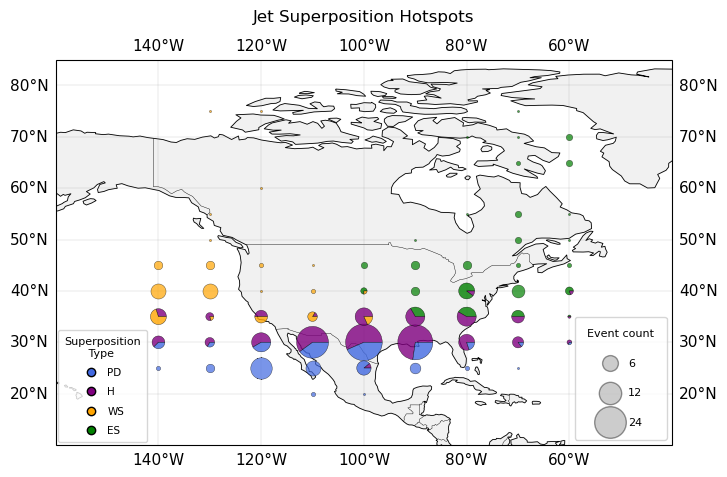

In [32]:
plot_superposition_hotspots(superpositions, marker_scale=0.0155, grid_res=(10,5))

In [33]:
def plot_all_superpositions(superpositions):
    """
    Plot every individual jet superposition on a map.
    - Dot = one event
    - Color = regime
    - Very small markers
    """
    df = superpositions.to_pandas()
    if "Event_Longitude" not in df.columns or "Event_Latitude" not in df.columns:
        raise ValueError("Superpositions must include 'Event_Longitude' and 'Event_Latitude' columns.")

    df["Event_Longitude"] = ((df["Event_Longitude"] + 180) % 360) - 180 
    df = df.dropna(subset=["Event_Longitude", "Event_Latitude", "regime"])
    #df = df[df["regime"] != "SD"] 
    regime_colors = {
        "PD": "royalblue",
        "SD": "tomato",
        "H": "purple",
        "WS": "orange",
        "ES": "green"
    }

    fig = plt.figure(figsize=(11, 6))
    ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=210))
    ax.add_feature(cfeature.COASTLINE, lw=0.6)
    ax.add_feature(cfeature.BORDERS, lw=0.3)
    ax.add_feature(cfeature.LAND, color="lightgray", alpha=0.3)
    ax.gridlines(draw_labels=True, linewidth=0.3, color="gray", alpha=0.4)
    ax.set_extent([-155, -50, 20, 80]) 

    for regime, color in regime_colors.items():
        sub = df[df["regime"] == regime]
        ax.scatter(
            sub["Event_Longitude"],
            sub["Event_Latitude"],
            s=12,                     # adjust
            color=color,
            alpha=0.7,
            edgecolor="none",
            transform=ccrs.PlateCarree(),
            label=regime
        )
        
    ax.legend(
        title="Type",
        loc="lower left",
        fontsize=10,
        title_fontsize=9,
        frameon=True,
        fancybox=True,
        facecolor="white",
        edgecolor="gray"
    )

    plt.title("Jet Superpositions (1979-2010)", fontsize=12, pad=12)
    plt.show()

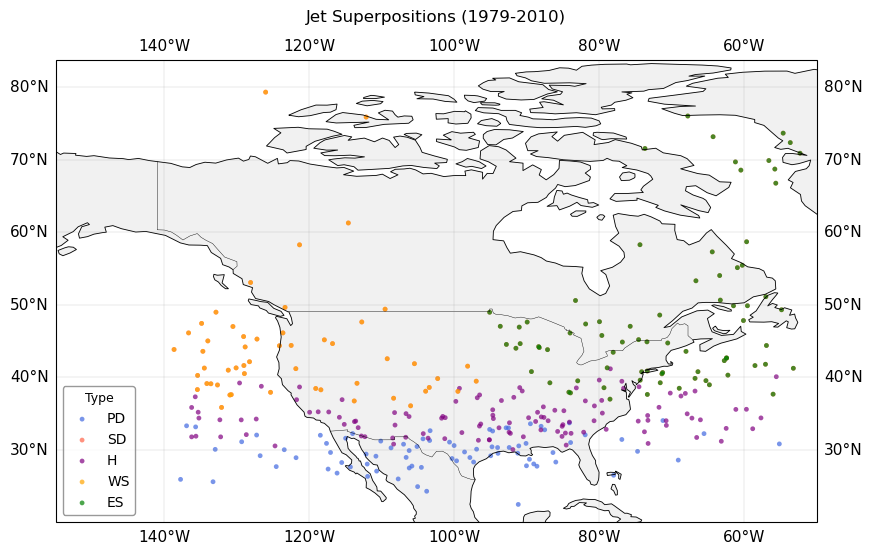

In [34]:
plot_all_superpositions(superpositions)

In [35]:
def plot_superposition_distribution(superpositions, coord="Latitude"):
    """
    Plot jet superposition distribution (violin + box) by regime.
    
    Parameters
    ----------
    superpositions : pl.DataFrame
        Must include columns 'regime' and either 'Event_Latitude' or 'Event_Longitude'.
    coord : str
        Either 'Latitude' or 'Longitude'.
    """
    regime_colors = {
        "PD": "royalblue",
        "SD": "tomato",
        "H": "purple",
        "WS": "orange",
        "ES": "green"
    }

    order = list(regime_colors.keys())

    coord = coord.capitalize()
    col_name = f"Event_{coord}"
    label = f"Event {coord} (°)"

    df = superpositions.select([col_name, "regime"]).to_pandas()
    df = df.dropna(subset=[col_name, "regime"])
    df = df[df["regime"].isin(order)]

    if coord == "Latitude":
        plt.figure(figsize=(10, 4))
        sns.violinplot(
            data=df,
            x="regime",
            y=col_name,
            inner="box",
            order=order,
            palette=regime_colors
        )
        plt.ylabel(label)
        plt.xlabel("Jet Regime")
        plt.grid(axis="y", linestyle="--", alpha=0.3)
        
    elif coord == "Longitude":
        plt.figure(figsize=(4, 5))
        sns.violinplot(
        data=df,
        y="regime",
        x=col_name,
        inner="box",
        order=order,
        palette=regime_colors,
        orient="h"
    )
        plt.xlabel(label)
        plt.ylabel("Jet Regime")
        plt.grid(axis="x", linestyle="--", alpha=0.3)

        # Clean axis limits & ticks
        plt.xlim(-180, 0)
        plt.xticks(range(-180, 1, 30))
        plt.axvline(0, color="gray", lw=0.8, ls="--", alpha=0.6)

    plt.title(f"Jet Superposition {coord} by Regime", fontsize=12, pad=10)
    plt.tight_layout()
    plt.show()

/tmp/ipykernel_2297676/3084848797.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


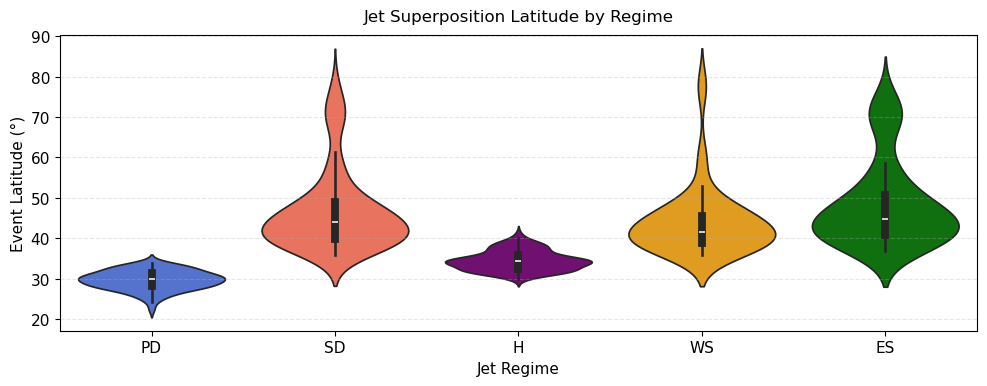

In [36]:
plot_superposition_distribution(superpositions, coord="Latitude")

/tmp/ipykernel_2297676/3084848797.py:46: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


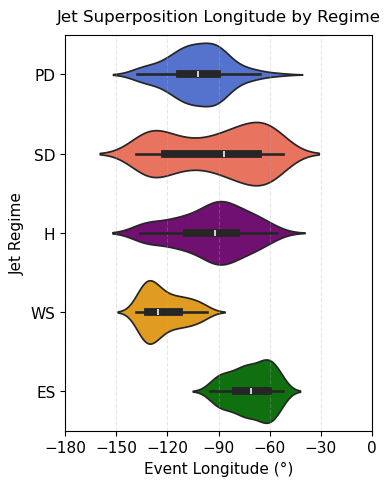

In [24]:
plot_superposition_distribution(superpositions, coord="Longitude")